## Testing BARTTSAgent with a Simulation

In this notebook we define a simple scenario (LinearScenario) and a simulation function. The simulation runs a loop over several rounds (draws) in which, at each round, the scenario generates covariates and rewards. Each agent (here a BARTTSAgent) selects an arm based on its current state, the cumulative regret is updated, and the agent’s state is updated with the observed reward.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from bart_playground.bandit.agent import BARTTSAgent

### Scenario Classes

We define a base `Scenario` class and a `LinearScenario` subclass. The `generate_covariates` method produces a vector of features (here, sampled from a standard normal distribution), and the `reward_function` computes the expected reward for each arm and adds noise.


In [5]:
class Scenario:
    def __init__(self, P, K, sigma2):
        """
        Parameters:
            P (int): Number of covariates (features).
            K (int): Number of arms.
            sigma2 (float): Noise variance.
        """
        self.P = P
        self.K = K
        self.sigma2 = sigma2

    def generate_covariates(self):
        # Generate a vector of P covariates (features) sampled from a normal distribution.
        return np.random.normal(0, 1, size=self.P)

    def reward_function(self, x):
        """
        Given a feature vector x, compute:
          - outcome_mean: Expected rewards for each arm.
          - reward: Outcome_mean plus noise.
        Must be implemented in subclasses.
        """
        raise NotImplementedError("This method should be implemented in subclasses.")

class LinearScenario(Scenario):
    def __init__(self, P, K, sigma2):
        super().__init__(P, K, sigma2)
        # Generate a K x P matrix of arm-specific coefficients uniformly between -1 and 1.
        self.mu_a = np.random.uniform(-1, 1, size=(K, P))
    
    def reward_function(self, x):
        # Compute noise for each arm.
        epsilon_t = np.random.normal(0, np.sqrt(self.sigma2), size=self.K)
        # Compute expected rewards (outcome means) for each arm.
        outcome_mean = 10 * self.mu_a.dot(x)
        return {"outcome_mean": outcome_mean, "reward": outcome_mean + epsilon_t}

### Simulation Function

The `simulate` function takes a scenario, a list of agents, and the number of draws. For each draw:

1. Generate covariates.
2. Compute the outcome means and rewards.
3. For each agent, choose an arm based on the current covariates.
4. Update cumulative regret for the agent.
5. Update the agent’s state with the observed reward.

We use `tqdm` to track progress.

In [6]:
def simulate(scenario, agents, n_draws):
    """
    Simulate a bandit problem using the provided scenario and agents.
    
    Parameters:
        scenario: An instance of a Scenario subclass.
        agents (list): List of agent instances (e.g. BARTTSAgent).
        n_draws (int): Number of simulation rounds.
    
    Returns:
        cum_regrets (np.ndarray): Cumulative regrets for each agent over draws.
        time_agent (np.ndarray): Total computation time (in seconds) for each agent.
    """
    n_agents = len(agents)
    cum_regrets = np.zeros((n_draws, n_agents))
    time_agent = np.zeros(n_agents)
    
    for draw in tqdm(range(n_draws), desc="Simulating"):
        x = scenario.generate_covariates()
        u = scenario.reward_function(x)
        outcome_mean = u["outcome_mean"]
        for i, agent in enumerate(agents):
            t0 = time.time()
            arm = agent.choose_arm(x)
            # Calculate instantaneous regret: difference between best expected reward and the reward of the chosen arm.
            inst_regret = max(outcome_mean) - outcome_mean[arm]
            # Accumulate regret over draws.
            if draw == 0:
                cum_regrets[draw, i] = inst_regret
            else:
                cum_regrets[draw, i] = cum_regrets[draw - 1, i] + inst_regret
            # Update agent's state with the chosen arm's data.
            agent.update_state(arm, x, u["reward"][arm])
            time_agent[i] += time.time() - t0
    return cum_regrets, time_agent

### Running the Simulation
 
In this example, we set up a scenario with a given number of arms and features, create a single BARTTSAgent (or you could create a list of agents), run the simulation for a fixed number of draws, and then plot the cumulative regret over time.

In [7]:
# Simulation parameters
n_arms = 3
n_features = 4
n_draws = 100

# Create a scenario instance (LinearScenario in this example)
scenario = LinearScenario(P=n_features, K=n_arms, sigma2=1.0)

# Create a list of agents.
# Here, we assume that BARTTSAgent is defined as shown in the previous cell.
agent = BARTTSAgent(n_arms=n_arms, n_features=n_features, nskip=10)
agents = [agent]

# Run the simulation.
cum_regrets, time_agent = simulate(scenario, agents, n_draws)

Simulating: 100%|██████████| 100/100 [02:34<00:00,  1.54s/it]


### Plotting the Results

We plot the cumulative regret over simulation draws.

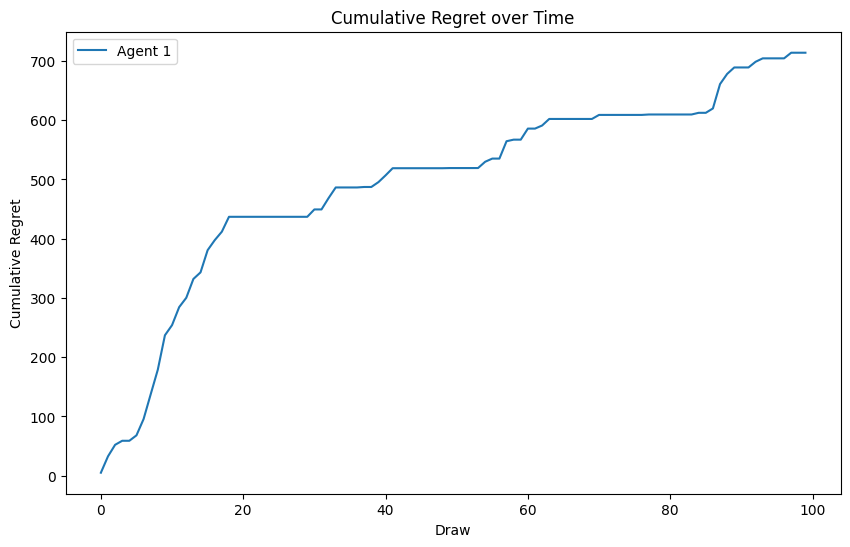

Agent computation times (seconds): [154.02726936]


In [9]:

plt.figure(figsize=(10, 6))
for i, agent in enumerate(agents):
    plt.plot(cum_regrets[:, i], label=f"Agent {i+1}")
plt.xlabel("Draw")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret over Time")
plt.legend()
plt.show()

print("Agent computation times (seconds):", time_agent)